#### <b>필요한 라이브러리 불러오기</b>

* 실습을 위해 필요한 라이브러리를 불러옵니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda")

#### <b>학습 데이터 생성</b>

* <b>사인(Sine) 함수</b>를 이용해 데이터를 생성합니다.

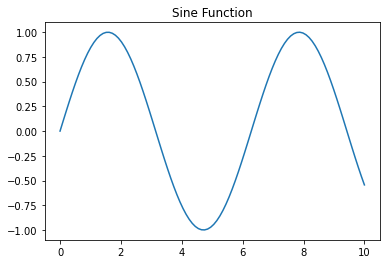

In [ ]:
data_size = 100

data_x = np.linspace(0, 10, data_size) # 0부터 10까지 100개의 포인트 설정
data_y = np.sin(data_x) # 각 포인트에 대한 sine() 값 계산

plt.title("Sine Function")
plt.plot(data_x, data_y)
plt.show()

* 사인(Sine) 함수의 값을 이용해 학습용 데이터셋을 생성합니다.

In [ ]:
sequence_size = 5
train_size = data_size - sequence_size

train_X = []
train_Y = []

for i in range(0, train_size):
    train_X.append(data_y[i:i + sequence_size]) # 앞의 5개가 주어졌을 때
    train_Y.append(data_y[i + sequence_size]) # 다음 값을 맞추는 문제

train_X = np.array(train_X)
train_Y = np.array(train_Y)

# [시퀀스의 개수, 시퀀스 크기]
print(train_X.shape)
print(train_Y.shape)

train_X = torch.from_numpy(train_X)
train_Y = torch.from_numpy(train_Y)

# PyTorch에서 사용할 수 있는 형태로 변환 후에 GPU로 옮기기
train_X = torch.transpose(train_X, 0, 1).unsqueeze(2).float().to(device)
train_Y = train_Y.unsqueeze(1).float().to(device)

print(train_X.shape) # [시퀀스 크기, 시퀀스 개수, 1]
print(train_Y.shape)

(95, 5)
(95,)
torch.Size([5, 95, 1])
torch.Size([95, 1])


#### <b>RNN 모델 정의하기</b>

* 하이퍼 파라미터를 설정합니다.
* RNN 모델을 정의합니다.

In [ ]:
input_dim = 1
output_dim = 1
hidden_dim = 1000

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(RNN, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.w_xh = nn.Linear(self.input_dim, self.hidden_dim)
        self.w_hh = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.w_hy = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x, h):
        h = nn.Tanh()(self.w_xh(x) + self.w_hh(h))
        y = self.w_hy(h)
        return y, h

#### <b>RNN 모델 학습하기</b>

* RNN 모델을 학습합니다.

In [ ]:
# 현재 모델의 출력을 확인
def show(rnn):
    rnn.eval()
    predictions = []

    # 현재 예제에서는 [학습 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(train_size, hidden_dim).to(device)

    # 시퀀스에 포함된 데이터를 연속적으로 넣기
    for x in train_X:
        y_pred, h = rnn(x, h)

    plt.title("Prediction Result")
    plt.plot(data_x[sequence_size:], data_y[sequence_size:])
    plt.plot(data_x[sequence_size:], y_pred.view(-1).cpu().detach().numpy())
    plt.legend(["Real", "Predicted"])
    plt.show()

[ Training Start ]


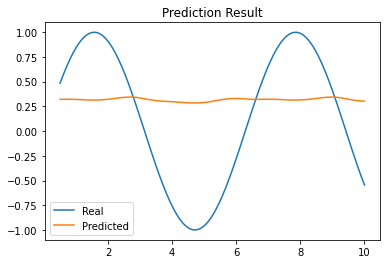

[1000/10000] loss = 8.604033610026818e-06


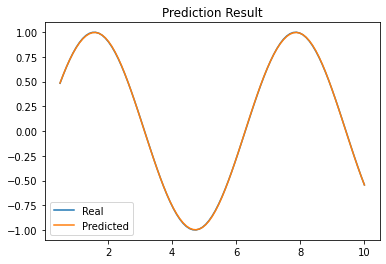

[2000/10000] loss = 2.172637323383242e-06


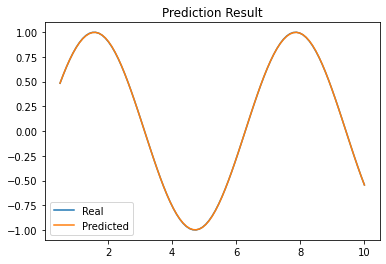

[3000/10000] loss = 1.095228299163864e-06


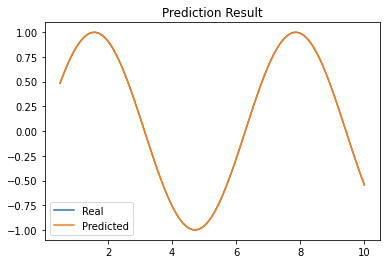

[4000/10000] loss = 8.690261665833532e-07


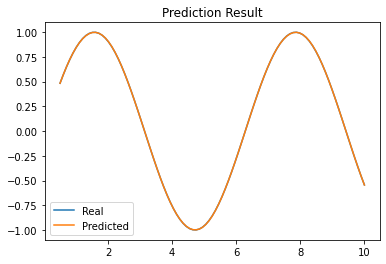

[5000/10000] loss = 7.884160595494905e-07


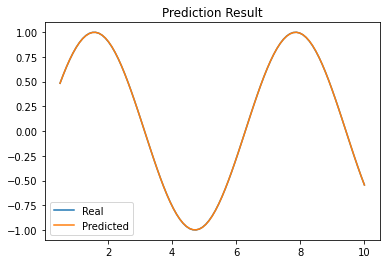

[6000/10000] loss = 7.374266601800628e-07


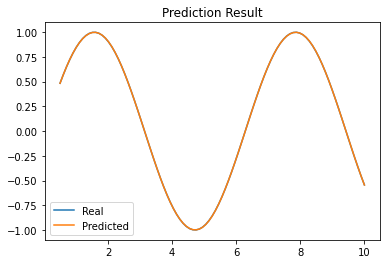

[7000/10000] loss = 6.956098559385282e-07


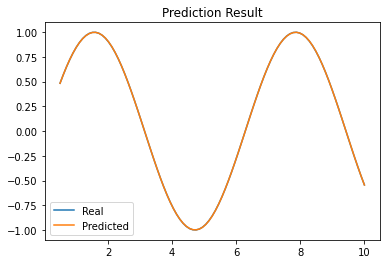

[8000/10000] loss = 6.58779640616558e-07


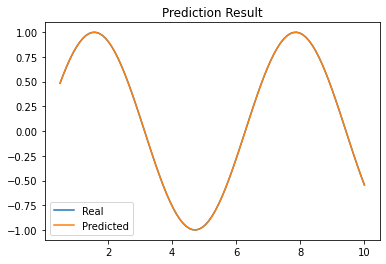

[9000/10000] loss = 6.256767619561288e-07


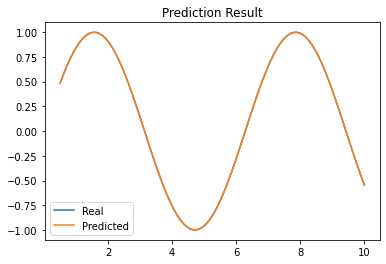

[10000/10000] loss = 5.955648134658986e-07


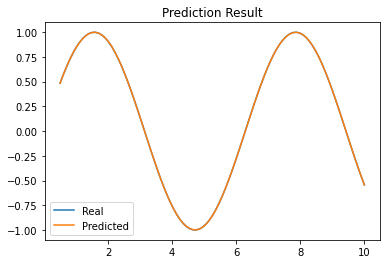

In [ ]:
rnn = RNN(input_dim, output_dim, hidden_dim).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005, momentum=0.9)

print("[ Training Start ]")
show(rnn)

epoch = 10000

for i in range(epoch):
    rnn.train()
    rnn.zero_grad()
    optimizer.zero_grad()

    # 현재 예제에서는 [학습 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(train_size, hidden_dim).to(device)

    # 시퀀스에 포함된 데이터를 연속적으로 넣기
    for x in train_X:
        y_pred, h = rnn(x, h)

    # 손실(loss) 값을 계산하여 학습 진행
    loss = loss_fn(train_Y, y_pred)
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 1000 == 0:
        print(f"[{i + 1}/{epoch}] loss = {loss.item()}")
        show(rnn)

#### <b>자동으로 결과 예측해 보기</b>

* 초반의 데이터만 입력한 상태에서 앞으로의 모든 결과를 예측해 봅시다.

In [ ]:
# 평가를 위한 하나의 시퀀스 생성
test_X = train_X[:, 0, :].unsqueeze(2)
print(test_X.shape)

rnn.eval()
predictions = []

for i in range(1000):
    # 현재 예제에서는 [평가 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(1, hidden_dim).to(device)

    # 시퀀스에 포함된 데이터를 연속적으로 넣기
    for x in test_X:
        y_pred, h = rnn(x, h)

    test_X = torch.cat((test_X, y_pred.unsqueeze(0)), dim=0)[1:]
    predictions.append(y_pred.item())

torch.Size([5, 1, 1])


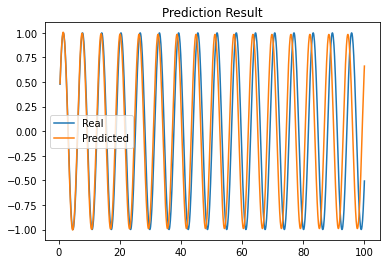

In [ ]:
test_x = np.linspace(0, 100, 1000 + sequence_size)
test_y = np.sin(test_x) # 각 포인트에 대한 sine() 값 계산

plt.title("Prediction Result")
plt.plot(test_x[sequence_size:], test_y[sequence_size:])
plt.plot(test_x[sequence_size:], predictions)
plt.legend(["Real", "Predicted"])
plt.show()

#### <b>생각해 볼거리</b>

* 본 문제를 해결하기 위해서는 뉴럴 네트워크를 완전히 <b>과적합(overfitting)</b> 시켜야 합니다.
* <b>반복 횟수(epoch)</b>가 작아도 잘 동작하는 것처럼 보이는데, 반복 횟수(epoch)를 줄이면 어떻게 될까요?
    * 네트워크가 과적합(overfitting) 되려면 큰 수의 epoch이 필요할 수 있습니다.
* <b>데이터 개수를 더 늘리면</b> 어떻게 될까요?
    * 단순히 데이터의 개수를 늘렸을 때 발생하는 문제의 원인을 찾아봅시다.
* 시퀀스의 길이를 더 늘리면 어떻게 될까요?
    * <b>긴 시퀀스</b>에 대하여 잘 동작하는 LSTM에 대하여 공부해 봅시다.
* 사인(sine) 함수가 아닌 조금 더 <b>복잡한 함수</b>를 사용하면 어떻게 될까요?